In [1]:
library(arrow)
library(cowplot)
library(tidyverse)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ lubridate::stamp()    masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
make_plots <- function(name) {
    gwas_summary_df <- read_parquet(str_glue("data/gwas_summary/{name}.parquet"))
    pheno_summary_df <- read_parquet(str_glue("data/pheno_summary/{name}.parquet"))

    if ("k" %in% colnames(gwas_summary_df)) {
        join_cols <- c("kind", "phenotype", "k")
    } else {
        join_cols <- c("kind", "phenotype")
    }

    
    summary_df <- gwas_summary_df |>
        inner_join(pheno_summary_df, by = join_cols, suffix = c("_gwas", "_pheno")) |>
        mutate(
            operator = if_else(kind == "boolean", str_extract(phenotype, "^([a-z]+)(?=_)"), "phecode"),
            kind = kind |> factor(levels = c("phecodes", "boolean"))
        )
    
    phenotype_fidelity_plot <- summary_df |>
        ggplot(aes(x = operator, y = rsq_pheno, fill = operator)) +
        geom_violin() +
        facet_grid(cols = vars(kind), scales = "free", space = "free") +
        theme_cowplot() +
        panel_border() +
        theme(
            legend.position = "none",
            strip.background = element_blank(),
            strip.clip = "off",
        ) +
        ylab("Phenotype fit quality") +
        scale_y_continuous(limits = c(-1, 1)) +
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50")
    
    gwas_fidelity_plot <- summary_df |>
        ggplot(aes(x = operator, y = rsq_gwas, fill = operator)) +
        geom_violin() +
        facet_grid(cols = vars(kind), scales = "free", space = "free") +
        theme_cowplot() +
        panel_border() +
        theme(
            legend.position = "none",
            strip.background = element_blank(),
            strip.clip = "off",
        ) +
        ylab("GWAS fidelity") +
        scale_y_continuous(limits = c(-1, 1)) +
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50")
    
    pheno_vs_gwas_plot <- summary_df |>
        ggplot(aes(x = rsq_pheno, y = rsq_gwas, color = operator)) +
        geom_point(alpha = 0.25) +
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray50") +
        theme_cowplot() +
        panel_border() +
        theme(
            strip.background = element_blank(),
            strip.clip = "off",
        ) +
        xlab("Phenotype fit quality") +
        ylab("GWAS fidelity") + 
        scale_y_continuous(limits = c(-1, 1), breaks = c(-1, 0, 1)) + 
        scale_x_continuous(limits = c(-1, 1), breaks = c(-1, 0, 0.5, 1)) + 
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50") +
        geom_vline(xintercept = c(0, 1), linetype = "dashed", color = "gray50") +
        geom_vline(xintercept = 0.5, linetype = "dashed", color = "gray80")

    result <- list(
        "df" = summary_df,
        "pheno" = phenotype_fidelity_plot, 
        "gwas" = gwas_fidelity_plot,
        "pheno_vs_gwas" = pheno_vs_gwas_plot
    )
    return(result)
}

# Direct vs indirect non-anon

Just the quality loss due to linearization

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


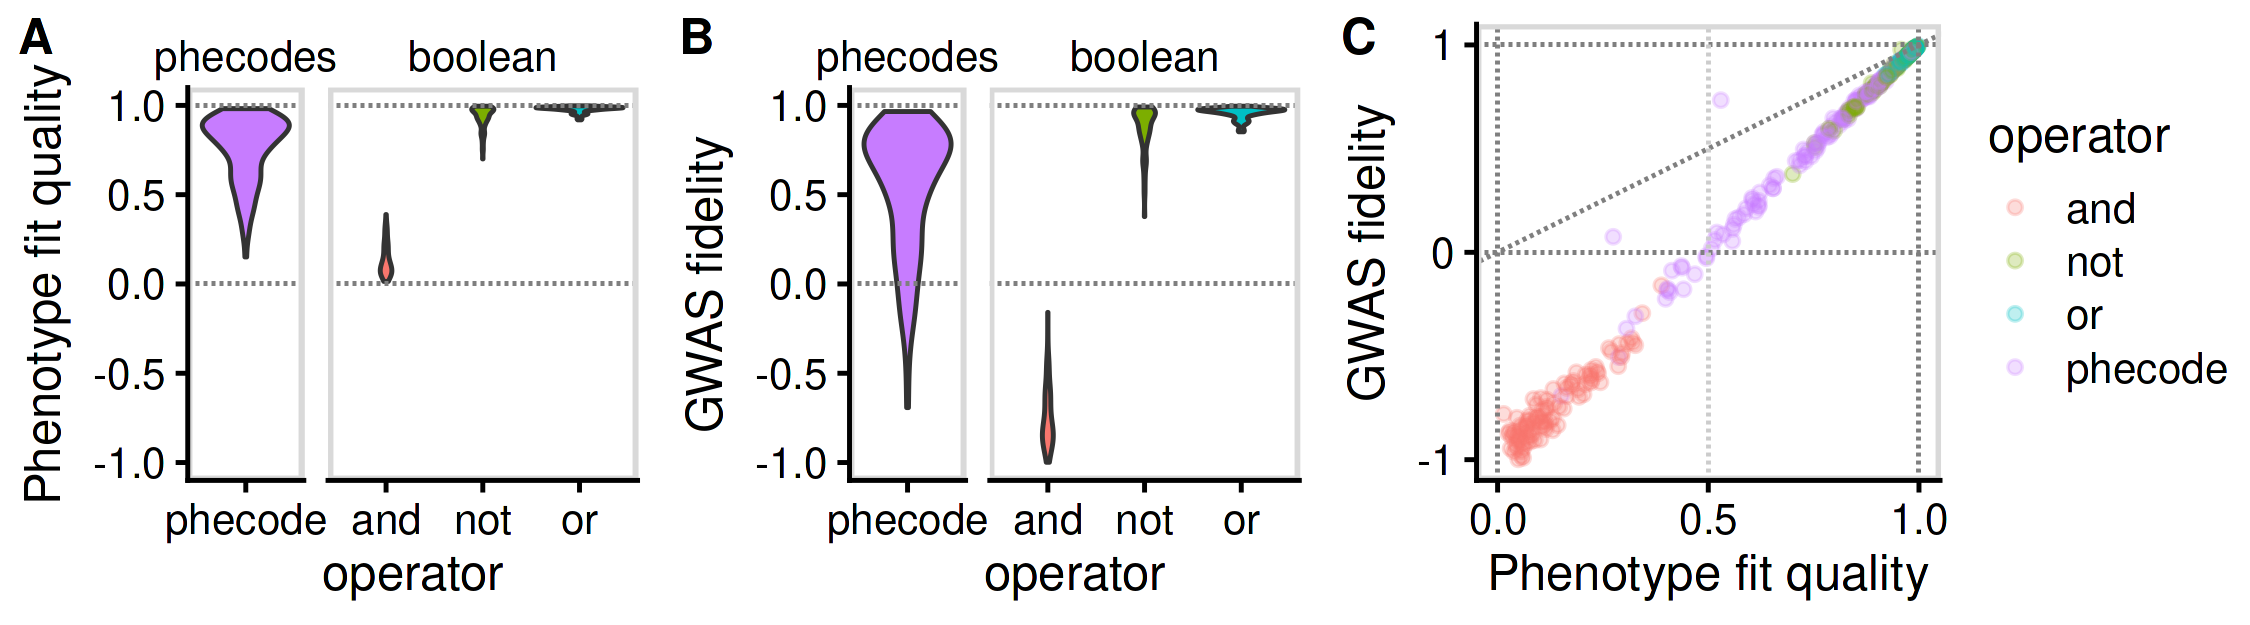

In [3]:
direct_vs_indirect_non_anon_plots <- make_plots("direct_vs_indirect_non_anon")

options(repr.plot.width = 9, repr.plot.height = 2.5, repr.plot.res = 250)

plot_grid(
    direct_vs_indirect_non_anon_plots[["pheno"]],
    direct_vs_indirect_non_anon_plots[["gwas"]],
    (
        direct_vs_indirect_non_anon_plots[["pheno_vs_gwas"]] +
        scale_x_continuous(limits = c(0, 1), breaks = c(0, 0.5, 1))
    ),
    nrow = 1,
    labels = c("A", "B", "C"),
    rel_widths = c(1, 1, 1.4)
)

# Non-anon vs anon

Just quality loss due to anonymization

Warning message:
“Removed 469 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 469 rows containing missing values or values outside the scale range (`geom_point()`).”


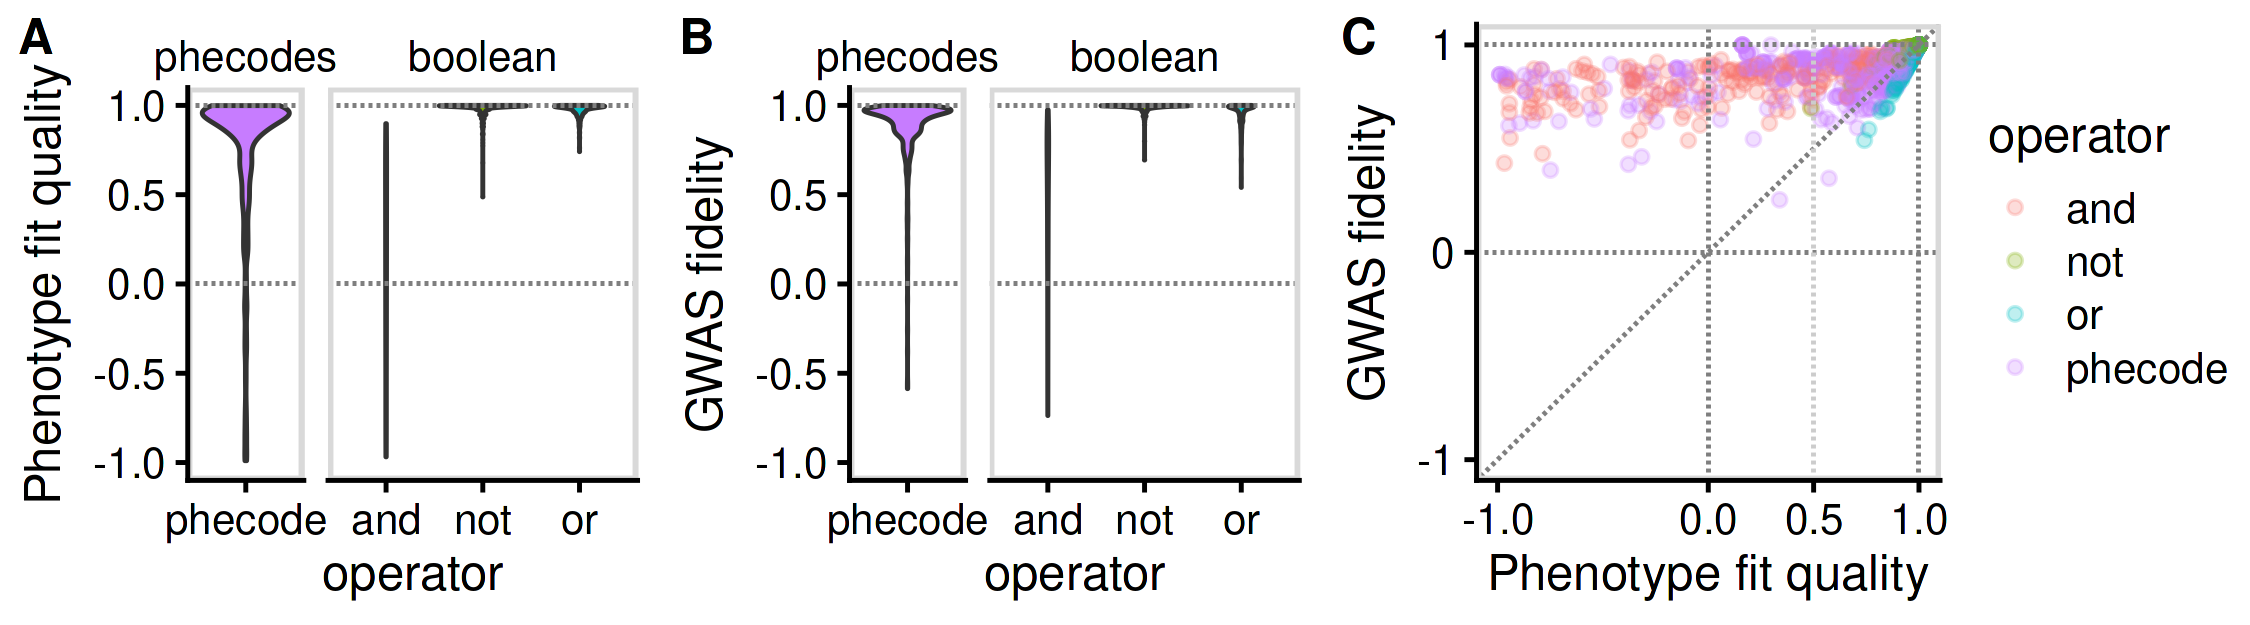

In [4]:
indirect_non_anon_vs_anon_plots <- make_plots("indirect_non_anon_vs_anon")

options(repr.plot.width = 9, repr.plot.height = 2.5, repr.plot.res = 250)

plot_grid(
    indirect_non_anon_vs_anon_plots[["pheno"]],
    indirect_non_anon_vs_anon_plots[["gwas"]],
    indirect_non_anon_vs_anon_plots[["pheno_vs_gwas"]],
    nrow = 1,
    labels = c("A", "B", "C"),
    rel_widths = c(1, 1, 1.4)
)

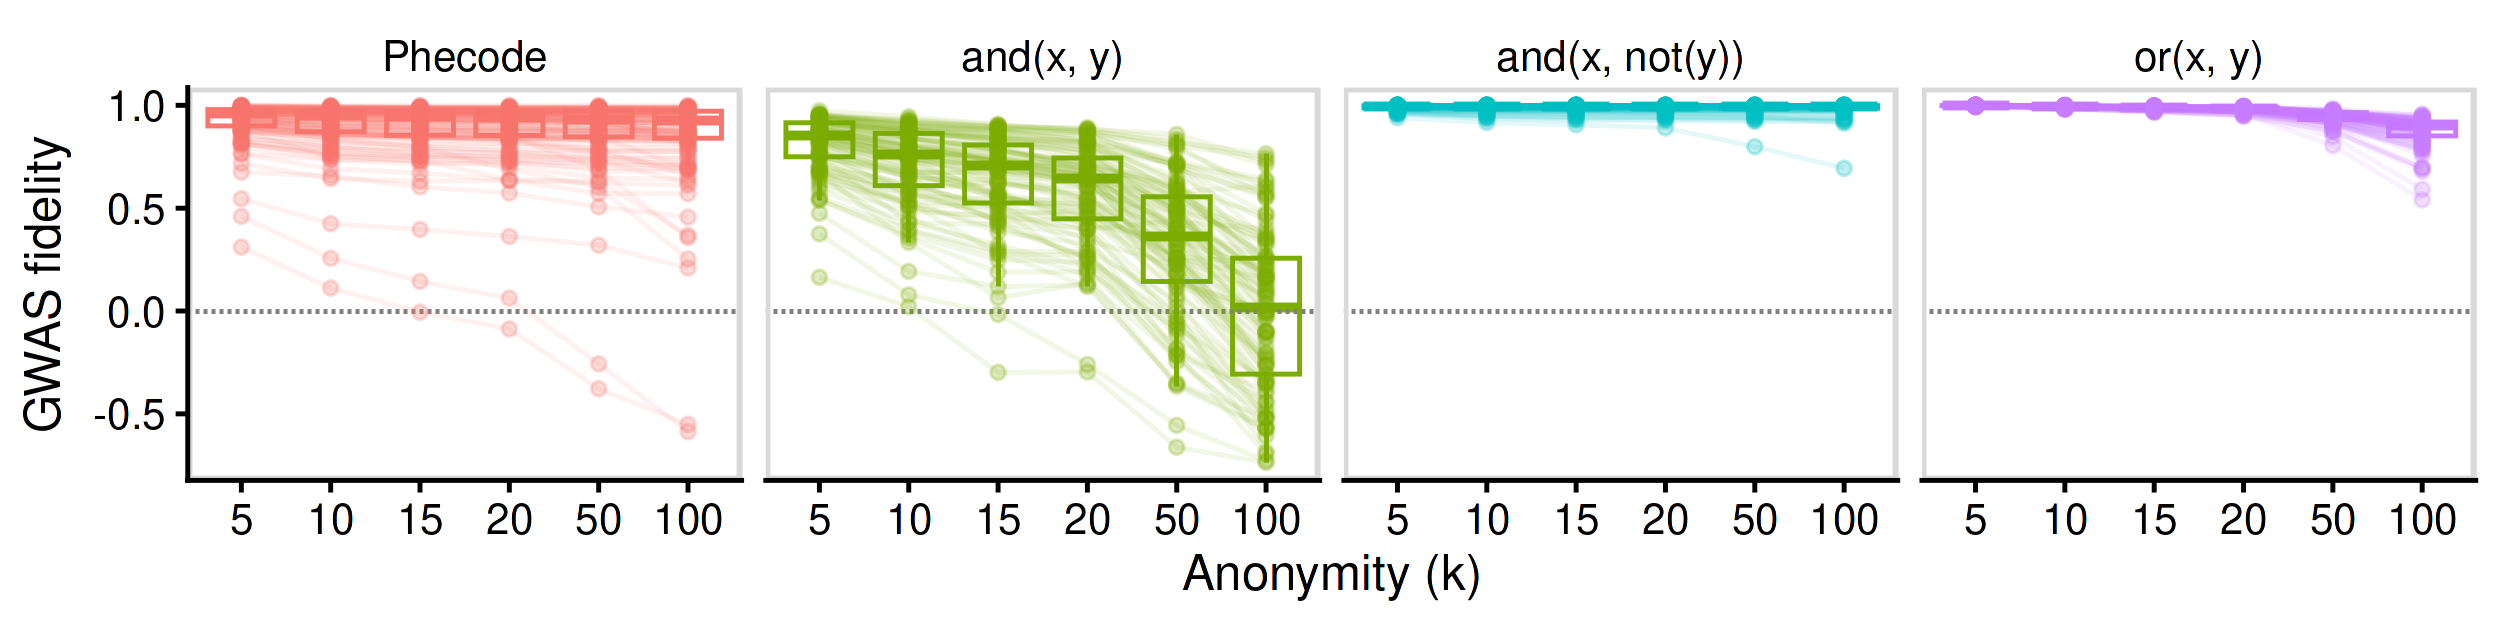

In [5]:
options(repr.plot.width = 10, repr.plot.height = 2.5, repr.plot.res = 250)

performance_vs_k_plot <- indirect_non_anon_vs_anon_plots[["df"]] |>
    mutate(
        operator = operator |> 
            recode_factor(
                phecode = "Phecode",
                and = "and(x, y)",
                not = "and(x, not(y))",
                or = "or(x, y)",
            ),
        k = k |> as.integer() |> as.character() |> factor(levels = c("5", "10", "15", "20", "50", "100")),
    ) |>
    ggplot(aes(x = k, y = rsq_gwas, color = operator)) +
    geom_boxplot(aes(group = k), outlier.shape = NA) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
    geom_line(aes(group = phenotype), alpha = 0.1) +
    geom_point(alpha = 0.25) +
    facet_grid(cols = vars(operator)) +
    theme_cowplot() +
    panel_border() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    xlab("Anonymity (k)") +
    ylab("GWAS fidelity")

save_plot("img/performance-vs-k.png", performance_vs_k_plot, base_width = 10, base_height = 2.5, dpi = 400)

performance_vs_k_plot

# Direct vs anon

Overall performance

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 211 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 225 rows containing missing values or values outside the scale range (`geom_point()`).”


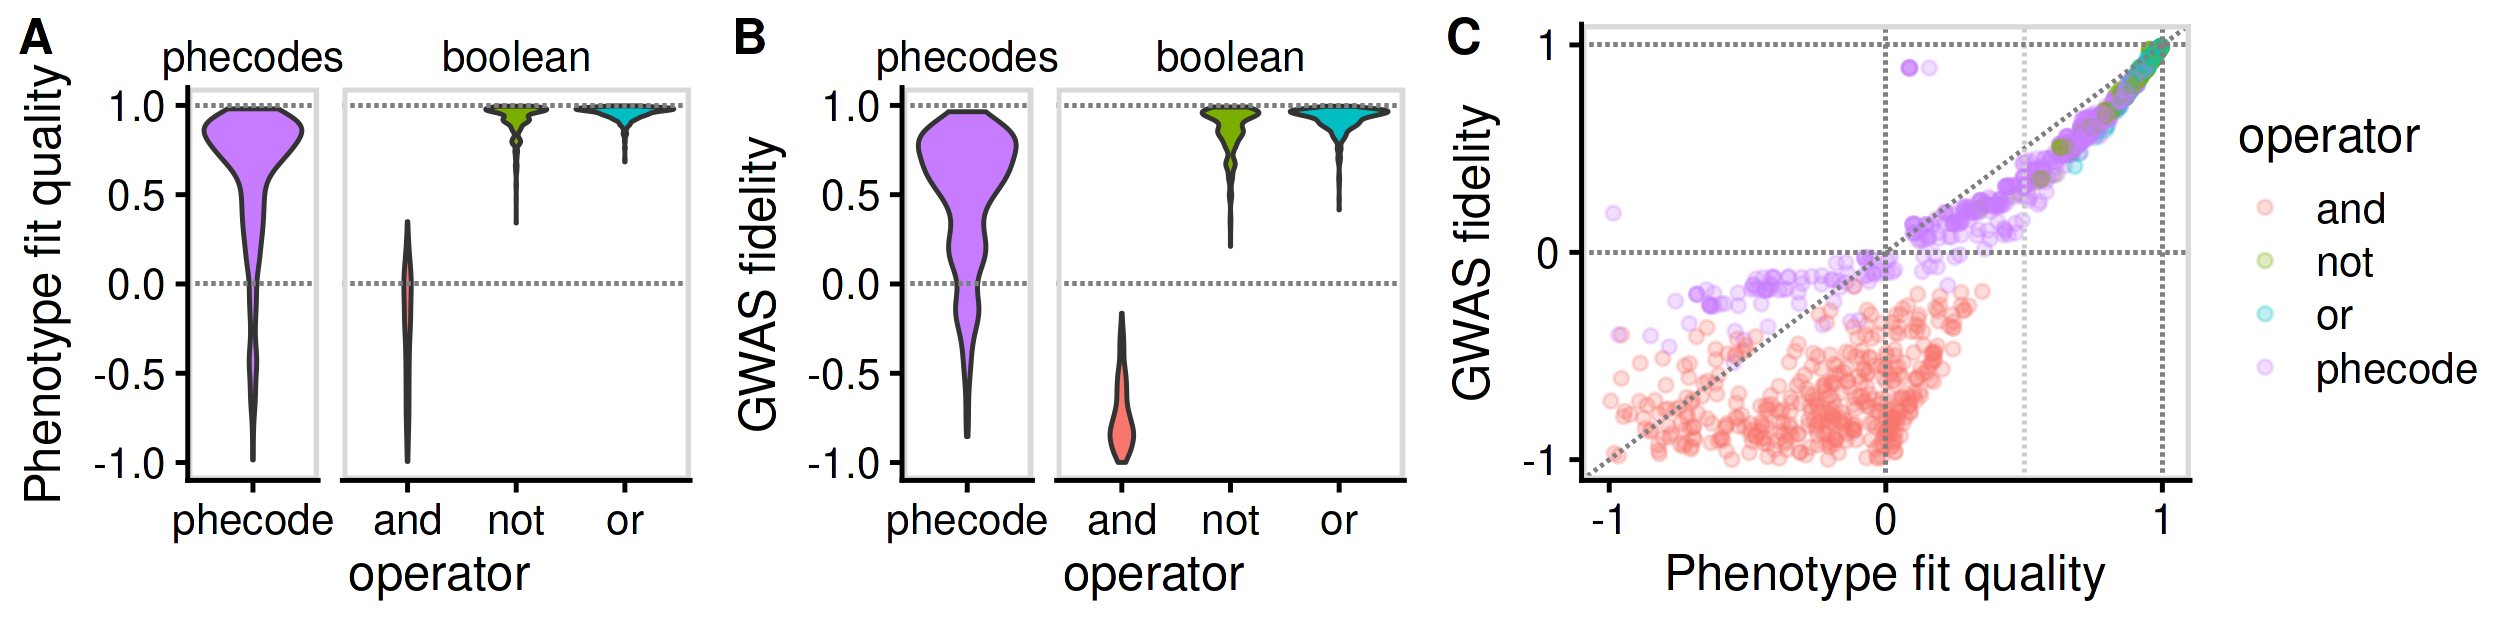

In [6]:
direct_vs_indirect_anon_plots <- make_plots("direct_vs_indirect_anon")

options(repr.plot.width = 10, repr.plot.height = 2.5, repr.plot.res = 250)

plot_grid(
    (
        direct_vs_indirect_anon_plots[["pheno"]] +
        scale_y_continuous(limits = c(-1, 1)) +
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50")
    ),
    (
        direct_vs_indirect_anon_plots[["gwas"]] +
        scale_y_continuous(limits = c(-1, 1)) +
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50")
    ),
    (
        direct_vs_indirect_anon_plots[["pheno_vs_gwas"]] + 
        scale_y_continuous(limits = c(-1, 1), breaks = c(-1, 0, 1)) + 
        scale_x_continuous(limits = c(-1, 1), breaks = c(-1, 0, 1)) + 
        geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "gray50") +
        geom_vline(xintercept = c(0, 1), linetype = "dashed", color = "gray50")
    ),
    nrow = 1,
    labels = c("A", "B", "C"),
    rel_widths = c(1, 1, 1.5)
)